Importare le librerie


In [1]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import drive

True
Thu Jan 16 16:55:42 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

Caricare i dati

In [2]:
# Caricare i dati da una directory organizzata in sottocartelle per classe
drive.mount('/content/drive')
!ls /content/drive/MyDrive

train_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/train'
test_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test'

# Trasformazioni per i dati (es. ridimensionamento, normalizzazione)
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Ridimensiona le immagini
    transforms.ToTensor(),          # Converte l'immagine in un tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Caricamento dei dati
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# Creazione dei DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Verifica della disponibilità della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

ValueError: mount failed

# Definire il modello
Il modello una rete neurale sequential con diverse fully connected layers. Un modello Sequential in Keras è una pila lineare di strati, dove ogni strato riceve in input l'output del precedente.

1. Flatten(input_shape=(150, 150, 3))
- Questo è il primo strato del modello.
  - Flatten converte l'input da una matrice 2D (ad esempio un'immagine di dimensioni 150×150×3) in un vettore 1D.

  - input_shape=(150, 150, 3) significa che il modello si aspetta immagini di dimensioni 150x150 pixel con 3 canali (RGB).
- Quindi, ogni immagine sarà "appiattita" in un singolo vettore con una lunghezza di 150×150×3=67500 valori.

2. Dense(128, activation='relu')
- Questo è un strato denso con 128 neuroni e attivazione ReLU.
  - Un strato denso (Fully Connected Layer) è un tipo di strato dove ogni neurone è connesso a tutti i neuroni dello strato precedente.
  - ReLU (Rectified Linear Unit) è una funzione di attivazione che restituisce il valore di input se è positivo, altrimenti restituisce 0. È ampiamente utilizzata nei modelli di deep learning per introdurre non linearità.

3. Dense(64, activation='relu')
- Questo è un altro strato denso con 64 neuroni e attivazione ReLU.
  - Simile al secondo strato, ma con meno neuroni (64). Serve a ridurre la complessità e a cercare una rappresentazione più astratta dei dati.

4. Dense(1, activation='sigmoid')
- Questo è lo strato di uscita del modello.
  - 1 neurone: Poiché stai facendo una classificazione binaria, hai bisogno di un solo neurone in uscita.
  - Sigmoid è una funzione di attivazione che restituisce un valore compreso tra 0 e 1, il che è perfetto per problemi di classificazione binaria.
  - Se l'output è vicino a 1, il modello prevede una classe, altrimenti prevede l'altra.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Definizione del modello
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(150 * 150 * 3, 128)  # Livello di input -> 128 neuroni
        self.fc2 = nn.Linear(128, 64)              # Livello intermedio -> 64 neuroni
        self.fc3 = nn.Linear(64, 1)                # Livello di output -> 1 neurone (per classificazione binaria)
        self.sigmoid = nn.Sigmoid()                # Funzione di attivazione sigmoid per l'output binario

    def forward(self, x):
        x = x.view(-1, 150 * 150 * 3)  # Flatten dell'input (da immagine a vettore)
        x = torch.relu(self.fc1(x))    # Attivazione ReLU sul primo strato
        x = torch.relu(self.fc2(x))    # Attivazione ReLU sul secondo strato
        x = self.sigmoid(self.fc3(x))  # Funzione sigmoide per l'output
        return x

# Creazione del modello
model = BinaryClassifier().to(device)
print(model)


BinaryClassifier(
  (fc1): Linear(in_features=67500, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Funzione di perdita e ottimizzazione

In [ ]:
# Funzione di perdita e ottimizzatore
criterion = nn.BCELoss()  # Cross Entropy per classificazione binaria
optimizer = optim.Adam(model.parameters(), lr=0.001)


Addestrare il modello

In [ ]:
# Numero di epoche
num_epochs = 10

# Ciclo di addestramento
for epoch in range(num_epochs):
    model.train()  # Imposta il modello in modalità di allenamento
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Azzeriamo i gradienti
        optimizer.zero_grad()

        # Passaggio in avanti
        outputs = model(inputs)

        # Calcoliamo la perdita
        loss = criterion(outputs.squeeze(), labels.float())  # .squeeze() per rimuovere la dimensione extra di output
        loss.backward()  # Calcolo dei gradienti

        # Ottimizzazione
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Epoch [1/10], Loss: 0.6346447445226439
Epoch [2/10], Loss: 0.2701997200422215
Epoch [3/10], Loss: 0.2905757832905334
Epoch [4/10], Loss: 0.1952227937678496
Epoch [5/10], Loss: 0.18537451875762959
Epoch [6/10], Loss: 0.20227656716650183
Epoch [7/10], Loss: 0.21837310368816057
Epoch [8/10], Loss: 0.20933135565031658
Epoch [9/10], Loss: 0.175225396301936
Epoch [10/10], Loss: 0.17202986886894162


Valutazione del modello

In [ ]:
# Funzione per valutare il modello
def evaluate(model, test_loader):
    model.eval()  # Imposta il modello in modalità di valutazione
    correct = 0
    total = 0

    with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la valutazione
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()  # Predizione (0 o 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")

# Valutazione del modello sui dati di test
evaluate(model, test_loader)

Accuracy: 92.96875%


Matrice di confusione

Confusion Matrix:
[[204   5]
 [ 13  34]]


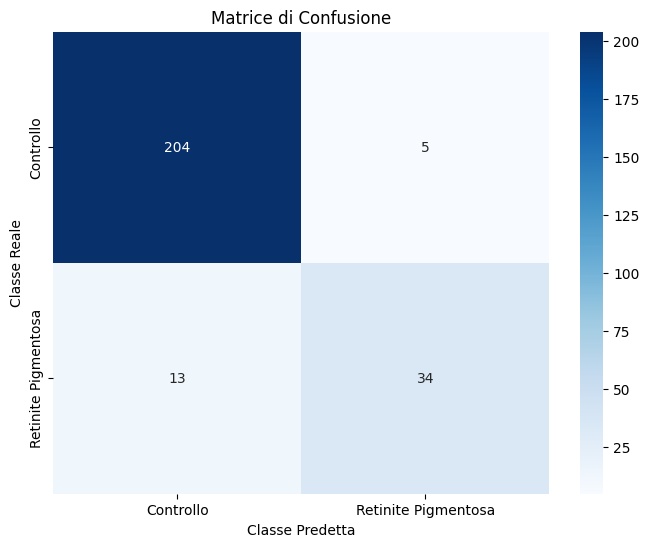

Classification Report:
                     precision    recall  f1-score   support

          Controllo       0.94      0.98      0.96       209
Retinite Pigmentosa       0.87      0.72      0.79        47

           accuracy                           0.93       256
          macro avg       0.91      0.85      0.87       256
       weighted avg       0.93      0.93      0.93       256



In [ ]:
import torch
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per calcolare e visualizzare la matrice di confusione
def confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = metrics.confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Visualizzazione della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.xlabel('Classe Predetta')
    plt.ylabel('Classe Reale')
    plt.show()

    # Report di classificazione
    print("Classification Report:")
    print(metrics.classification_report(all_labels, all_preds, target_names=class_names))

# Definisci le classi, modifica se necessario
class_names = ['Controllo', 'Retinite Pigmentosa']

# Calcolo e stampa della matrice di confusione
confusion_matrix(model, test_loader, class_names)


Utilizzare il modello

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Funzione per fare una previsione su una singola immagine
def predict(model, image_path):
    model.eval()

    # Caricamento e trasformazione dell'immagine
    transform = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Aggiungi una dimensione per batch
    image = image.to(device)

    # Predizione
    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        output = model(image)  # Passa l'immagine nel modello per ottenere la previsione
        prediction = (output.squeeze() > 0.5).float()  # Applica una soglia di 0.5 per classificare


    print(f"Predizione: {'Retinite Pigmentosa' if prediction == 1 else 'Controllo'}")

# Esegui una previsione su un'immagine
img_path = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test/retinite/Retinitis Pigmentosa73.jpg'
predict(model, img_path)

Predizione: Retinite Pigmentosa
